In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import pickle
import random
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
class artStylesDataset(Dataset):
    def __init__(self,data_dir,transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [3]:
class ArtsClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ArtsClassifier,self).__init__()
        self.base_model = timm.create_model("efficientnet_b0", pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size,num_classes)
        

    def forward(self,x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [4]:
transform = transforms.Compose([
    transforms.Resize((464,600)),
    transforms.ToTensor(),
])

model_path = "artPython_model.pkl"

data_dir = './Data'
dataset = artStylesDataset(data_dir, transform)

trainDataset = artStylesDataset("./Data", transform=transform)
validDataset = artStylesDataset("./Valid", transform=transform)
testDataset = artStylesDataset("./Test", transform=transform)

trainLoader = DataLoader(trainDataset,batch_size=32,shuffle=True)
validLoader = DataLoader(validDataset,batch_size=32,shuffle=True)
testLoader = DataLoader(testDataset,batch_size=32,shuffle=True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ArtsClassifier(num_classes=4)
model.to(device)

try:
    with open(model_path, 'rb') as file:  
        model = pickle.load(file)
except:
    pass

In [6]:
num_epoch = 5
trainLoss,valLoss = [], []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

print("Training session start")
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    for images,labels in tqdm(trainLoader,desc="Training progress"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss/len(trainLoader.dataset)
    trainLoss.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images,labels in tqdm(validLoader,desc="Validation progress"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(validLoader.dataset)
    valLoss.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training session start


Training progress:   0%|          | 0/15 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.4943203264396096, Validation loss: 0.4807491981705954


Training progress:   0%|          | 0/15 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.2360460763460739, Validation loss: 0.1251494439188824


Training progress:   0%|          | 0/15 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.14472273891455276, Validation loss: 0.2036203381627105


Training progress:   0%|          | 0/15 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.07732759754169355, Validation loss: 0.1312872102094251


Training progress:   0%|          | 0/15 [00:00<?, ?it/s]

Validation progress:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.11277637676651782, Validation loss: 0.23311901577683383


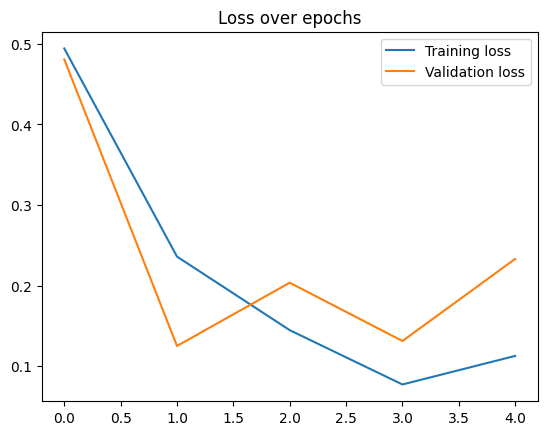

In [7]:
plt.plot(trainLoss, label="Training loss")
plt.plot(valLoss, label="Validation loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

Saving/Loading Model

In [8]:
with open(model_path, 'wb') as file:  
    pickle.dump(model, file)

Simple model test below

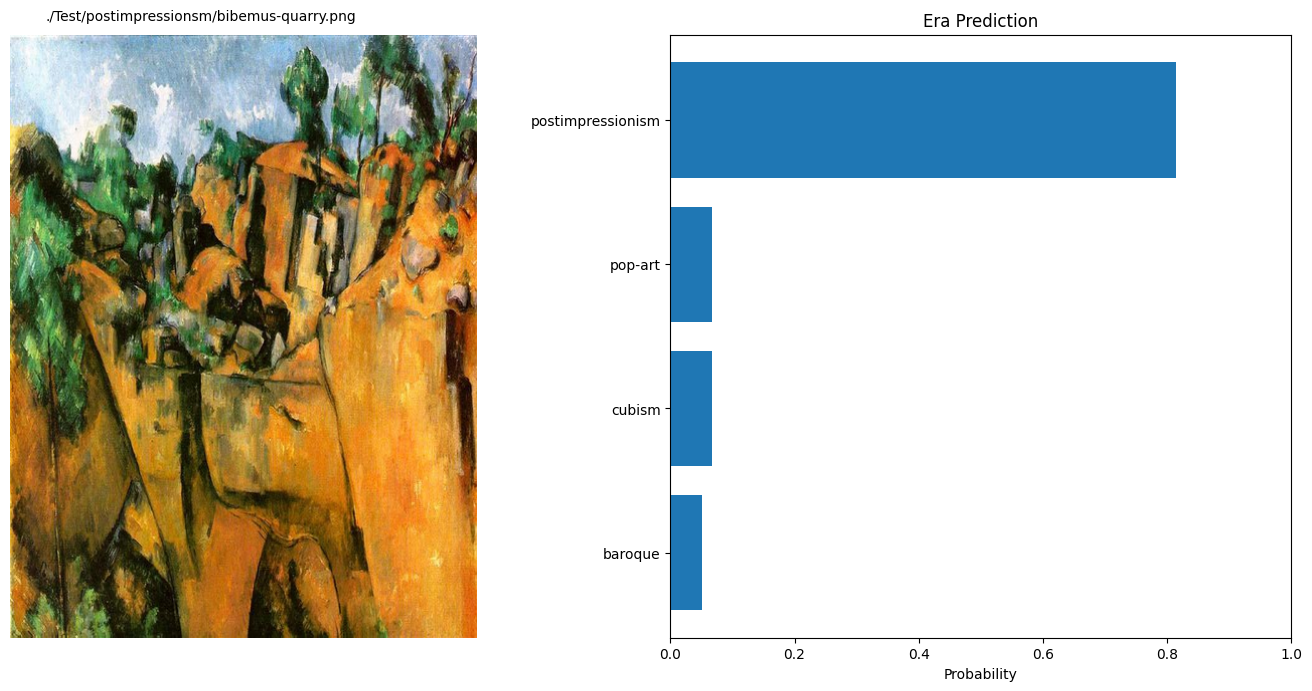

In [41]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names, picture_name):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].text(35,-15,picture_name)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Era Prediction")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

image_paths = [
    "./Test/baroque/christ-in-the-storm.png",
    "./Test/baroque/the-anatomy-lesson-of-dr-nicolaes-tulp.png",
    "./Test/pop-art/mickey.png",
    "./Test/pop-art/interior-with-mirrored-wall.png",
    "./Test/postimpressionsm/bibemus-quarry.png",
    "./Test/postimpressionsm/vase-with-peonies.png",
    "./Test/cubism/still-life-in-front-of-a-window-at-saint-raphael.png",
    "./Test/cubism/hobo.png"
]

test_image = random.choice(image_paths)

#Special Case
#test_image = "./Test/cubism/landscape-near-antwerp.png"
#test_image = "./christ-in-the-storm.png"

transform = transforms.Compose([
    transforms.Resize((464, 600)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names, test_image)

END